# Introduction to Pyro

http://pyro.ai/examples/intro_long.html

## Setup

In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

C:\Users\tmadsen\Miniconda3\envs\pyro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

In [3]:
pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [4]:
plt.style.use('default')

## Background

A probabilistic model is a joint probability distribution over a collection of random variables. A model has observations (**x**) and latent random variables (**z**) as well as parameters ($\theta$).

**Latent Variable**.  In statistics, latent variables are variables that are not directly observed but are rather inferred through a mathematical model from other variables that are observed. Mathematical models that aim to explain observed variables in terms of latent variables are called latent variable models. ([Wikipedia](https://en.wikipedia.org/wiki/Latent_variable))

## Example: Geography and National Income

The following example is adapted from Chapter 7 of the excellent book [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath, which readers are encouraged to review for an accessible introduction to the broader practice of Bayesian data analysis ([Pyro code](https://fehiepsi.github.io/rethinking-pyro/) for all chapters is available).

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable rugged in the dataset) and its GDP per capita. In particular, it was noted by the authors of the original paper ([“Ruggedness: The blessing of bad geography in Africa”](https://diegopuga.org/papers/rugged.pdf)) that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations.

In [9]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df.head()

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113


In [10]:
df = df[np.isfinite(df.rgdppc_2000)]
df.loc[:,"rgdppc_2000"] = np.log(df["rgdppc_2000"])
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


In [11]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gp = train[:, 0], train[:, 1], train[:, 2]

In [13]:
is_cont_africa

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1.])

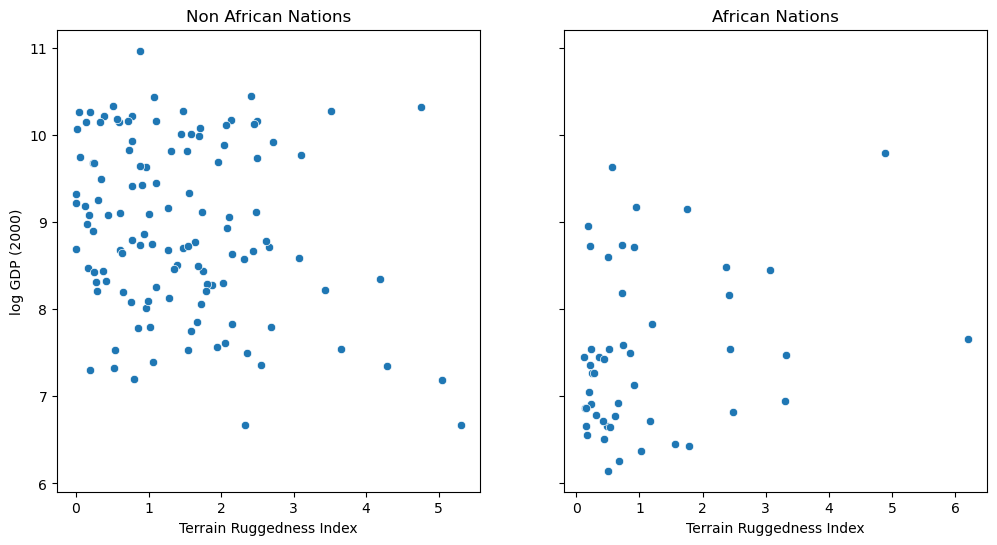

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Models in Pyro